<center>
<h1><strong>
TASK 1 - SpringerLink Discipline Prediction
</h1>
</center>


---


Authors: 
- Pablo Reyes Martín           (NIA: 100409333)
- Claudio Sotillos Peceros     (NIA: 100409401)
- Bosco De Enrique Romeu       (NIA: 100406718)
- Daniel De Las Cuevas Turel  (NIA: 100406666)  

<a href="https://link.springer.com/">SpringerLink's page</a>


# Brief Introduction

We have gathered our own dataset with information taken from the *American publishing company of academic journals and books*, **SpringerLink**. For more details of how we have built our own dataset, please check the *'Web Scraping'* Notebook.

The dataset contains around 18000 instances of Article metadata. The Articles belong to the following Disciplines: 

<center>
<h1>Disciplines
</center>

DSCP1 | DSCP2
---  | ---
**Computer Science**|**Philosophy**
**Mathematics**|**Psychology**
**Biomedicine**|**Criminology and Crime Justice**
**Geography**|**Education**
**Physics**|**Economics**

It consist of the following columns:

- Title of the Article
- Abstract of the Article
- KeyWords of the Abstract
- Authors of the Article
- Journal in which the article is published
- Publication Date
- Accesses to the Article
- url of the Article
- Target: Discipline at which the Article belongs to

However, we may delete or update some of the columns as we consider appropiate. 

Our main goal is try to predict, as accurately as possible, the target of a given instance taking into account the rest of the fields. 

<h1>Initialization</h1>

Let´s import all the needed libraries and tools

In [ ]:
# Common imports 
import numpy as np
import pandas as pd
import zipfile as zp
import random
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
import os
from google.colab import drive
import pickle
from collections import Counter
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

#For fancy table Display
%load_ext google.colab.data_table


# N Gram detection
from gensim.models.phrases import Phrases

# Data table (for representing better the df)
from google.colab import data_table
from collections import Counter

# Gensim 
import gensim
from gensim.models.ldamodel import LdaModel

# LDA Model 
from gensim.models import LdaModel
# Coherence Model
from gensim.models import CoherenceModel

# For Analyzing Semantic Similarity among documents
from gensim.matutils import corpus2csc
from scipy.sparse import triu
from ast import literal_eval


In [ ]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# THE BELOW LINE CODE HIDES THE OUTPUT OF THIS CELL. IF FOR ANY REASON THIS CELLS TAKES MORE THAN A MINUTE EXECUTING
# COMMENT THE BELOW LINE AND CHECK WHAT IS HAPPENING (IT IS POSSIBLE THAT MALLET MAKES EXTRANGE THINGS DURING ITS INSTALLATION)
%%capture   

!pip install --upgrade spacy
import spacy
!python -m spacy download en_core_web_md
!pip install --upgrade gensim==3.8.3
!pip install pyLDAvis==2.1.2

import os       #importing os to set environment variable
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
    !java -version       #check java version
install_java()

# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

# os.environ['MALLET_HOME'] = 'mallet-2.0.8'
# mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [ ]:
# pyLDAvis (quite useful for interpretting better our topic Modelling)
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [ ]:
drive.mount("/content/drive")

In [ ]:
# ¡WARNING! If you want to run the code, insert below the path where you have saved the 'Final Project' folder
local_folder = '/content/drive/MyDrive/ML Applications/Final Project/'
os.chdir(local_folder)


# 0.Loading our Dataset

In [ ]:
# We use pickle to load the clean data from the previous notebook
with open(local_folder + 'Task 1 CheckPoints/'+ "Dataset_clean.pickle", "rb") as metadata:
   data=pickle.load(metadata)

# We can see the structure of the dataset
data.head(1)

# 1.Dataset Analysis and Preprocessing

In [ ]:
print('Number of Documents:', len(data))
print('Mean Abstract length',np.mean(data['Abstract'].str.split().str.len().to_list()))
print('\nDataset Column Names')

# Showing the column names
data.columns.to_list()

In [ ]:
# We define a counter with the target variable
count = Counter(data.target.to_list())
keys = list(count)
 
# Getting values in the same order as keys, and parse percentage values
vals = [count[k] for k in keys]

# Plotting the number of projects per discipline
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
fig.suptitle('Distribution of the Disciplines')
sns.barplot(ax = axes, x=keys, y=vals)
plt.xticks(rotation=80)
plt.show()

In [ ]:
# Deleting the column 'urls'
data= data.drop(columns=['urls'])

In [ ]:
# Since the Accesses column is of String type, we want to convert its values to integers. 
# For doing so we have coded the below function. 

def remov_accss(access):
  if type(access) == str:
    #We remove any unnecessary character (that it is not an int)
    if access.split()[0][-1] == 'k':
      num = int(access.split()[0][0:-1])*1000
    else:
      num = int(access.split()[0])
  else:
    num = 0
  return num

In [ ]:
# Making some modifications in the columns 'Publication Date' and 'Accesses'

# Extracting the year from the 'Publication Date' Column
data['Year'] = list(map(lambda x: int(x[-4:]), data['Publication Date'].to_list()))    

# Extracting the Month from the 'Publication Date' Column
data['Month'] = list(map(lambda x: x.split()[1], data['Publication Date'].to_list()))  

# Applying the previous mentioned function (transform Accesses to integer)
data['Accesses']= data['Accesses'].apply(lambda x: remov_accss(x))                     

# Reordering DataSet Columns
data = data[['titles', 'Abstract', 'KeyWords', 'Authors', 'Journal','Publication Date','Month','Year',  'Accesses' , 'target']]   

# Showing first row
data.head(1)


<h3><strong>
Article Publication Year Plot
</h3>




In [ ]:
# We define a counter of the year variable in data
count = Counter(data['Year'])
keys = list(count)

# Getting values in the same order as keys
vals = [count[k] for k in keys]

# Plotting the number of documents per publication year
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
fig.suptitle('Distribution of Articles with respect the Publication Year')
sns.barplot(ax = axes, x=keys, y=vals)
plt.xticks(rotation=80)
plt.show()

<h3><strong>
Number of Accesses Per Discipline Plot
</h3>

In [ ]:
# Plotting the mean number of acceses per discipline
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="target", y="Accesses", data=data).set_title("Num of Accesses mean per discipline")
plt.xticks(rotation=80)
plt.show()

<h3><strong>
Abstract´s words mean per Discipline
</h3>

In [ ]:
# Plotting the mean number of abstract words for every discipline

data['Abs_count'] = data['Abstract'].str.split().str.len().to_list()
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="target", y="Abs_count", data=data).set_title("Abstract´s words mean per discipline")
plt.xticks(rotation=80)
plt.show()

<h3><strong>
Showing the month with the most number of articles published (by discipline)
</h3>

In [ ]:

#We iterate through every discipline
for i in data.target.unique():

  #We initialize a list where we will store the publication month for every article
  temp_lst = []

  #We go through every data element
  for j in range(len(data)):

    #We count the number of articles for each discipline
     if data.target[j] ==  i:
       
       #We append the count to the list each month
       temp_lst.append(data.Month[j])

#We build a list with the most common months (for every discipline).
mst_cmn= list(Counter(temp_lst).most_common(1)[0])

print('Discipline: ',i,'      Maximum Publication Month: ',mst_cmn)  

# **2. Preprocessing of the Article´s Abstracts**

### *2.1. Text Preprocessing*

We will code two different Text Processing pipelines. One for the abstracts and the other for the titles. 

The one for the titles will be very simple, just for keeping the most important words in them. 

In [ ]:
# ABSTRACT'S TEXT PROCESSING PIPE

# We load the spacy model
nlp = spacy.load('en_core_web_md')

# We disable parser and ner, since we will not be using them
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

# We will accept verbs, noun, adjectives and proper nouns in the part of speech tagging
valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])


# Text preopocessing function
def text_preprocessing(rawtext):

    # We first process the rawtext with the nlp function
    doc = nlp(rawtext)

    # Then, the resulting lemmatized text is the selection of tokens in doc that are accepted in the pipeline (alphanumeric, in PoS set and non-stop word)
    lemmatized = ' '.join([token.lemma_ for token in doc if (token.is_alpha == True) and (token.pos_ in valid_POS) and (not token.is_stop)])
       
    return lemmatized

In [ ]:
# Abstract PROCESSING

data_abstracts = data['Abstract'].to_list()
data_lemmas = []
nprojects = len(data_abstracts)

# We apply the previous function in every abstract and insert them to the list "data_lemmas"
for n, abstract in enumerate(data_abstracts):
    if not n%100:
        print('\rPreprocessing abstract', n, 'out of', nprojects, end='', flush=True)
    data_lemmas.append(text_preprocessing(abstract))

In [ ]:
# We build the preprocessed dataframe with all the columnms, including now the lemmas
df_preprocessing =  pd.DataFrame([[el['titles'],  data_lemmas[idx], el['KeyWords'], el['Authors'], el['Journal'], 
                     el['Publication Date'], el['Month'], el['Year'], el['Accesses'] , el['target']] for idx, el in data.iterrows()],
                   columns=['Title', 'Lemmas', 'Keywords', 'Authors', 'Journal','Publication Date','Month','Year','Accesses','target'])

In [ ]:
df_preprocessing.head(1)

Since performing the text preprocessing took some minutes, lets perform here the first data checkpoint.


In [ ]:
df_preprocessing.to_excel(local_folder + 'Task 1 CheckPoints/CheckPoint1/'  + 'df_text_preprocessing.xlsx', index=False)

## Data Checkpoint 1



In [ ]:
# Loading the first checkpoint
df_spring = pd.read_excel(local_folder+ 'Task 1 CheckPoints/CheckPoint1/' + 'df_text_preprocessing.xlsx')

## 2.2. Vectorization of the Abstracts

### 2.2.1. Ngram Detection

The reason why we have decided to add the N Gram detection to our pipeline is because the 11% of the Corpu's words are NGrams. We think that it is a reasonable enough amount for taking these into account.

We also believe that they can be of help to us when differentiating to which discipline a certain topic belongs. 

In [ ]:
# We obtain the corpus with the lemmas
mynewcorpus = [el.strip().split() for el in df_spring['Lemmas']]
lema_count = []

# Counting the number of lemmas in the corpus
for doc in mynewcorpus:
  for elem in doc:
      lema_count.append(elem)
print('There are ', len(lema_count), 'words in the Corpus')

In [ ]:
print(colored('Number of documents in corpus: '+str(len(mynewcorpus)), 'green'))
print(colored('\n============= First document in corpus =============', 'blue'))
print(mycorpus[0])

In [ ]:
# We build the n-gram model with the parameters we saw in class: minimum of 2gram and a threshold of 200
phrase_model = Phrases(mynewcorpus, min_count=2, threshold=20)

# We populate mycorpus again with ngrams
mynewcorpus = [el for el in phrase_model[mynewcorpus]] #We populate mycorpus again
print(colored('\n============= First document after N-gram replacement =============', 'blue'))
print(mynewcorpus[0])

In [ ]:
# We select ONLY the n-grams (looking for <word>_<word>)
N_gram = []
for doc in mynewcorpus:
  for elem in doc:
    if '_' in elem:
      N_gram.append(elem)

print('After applying the Ngram detection, there were found a total of ',len(N_gram),' Ngrams')
print('As we mentioned before, the Ngrams constitute almost the 11% of the Words of the Corpus: ', (len(N_gram)*100)/len(lema_count),'\n')

df = pd.DataFrame.from_dict(Counter(N_gram), orient='index').reset_index()
df = df.rename(columns={'index':'Ngram', 0:'count'})
data_table.DataTable(df, include_index=False)

Notice that because of making the Ngram detection, now our abstracts are in list form. That is why in the next code cells we will transform the abstracts back again to text. 

In [ ]:
type(mynewcorpus[0])

In [ ]:
# Functions which joins all the words of a list into a single string
def joinwrds(lst):
  return ' '.join(lst)

In [ ]:
# Update the lemmas variable and join the words into a string
df_spring['Lemmas'] = mynewcorpus
df_spring['Lemmas'] = df_spring['Lemmas'].apply(lambda x: joinwrds(x))

<h3><strong>
Removing short Abstracts
</h3></strong>
We may have set a relatively small threshold for the abstract number of words, however we have done this because in case we increased the threshold (to 100 for instance) almost all the Mathematics abstracts were removed (and the philosophy abstracts decreased a lot too). 

In [ ]:
# Show the distribution of the number of lemmas

df_spring['nlemmas'] = df_spring['Lemmas'].str.split().str.len()
plt.hist(df_spring['nlemmas'].tolist() ,100)
plt.show()

In [ ]:
# We delete the articles with less than 40 lemmas

df_spring = df_spring[df_spring['nlemmas']>=40]
print('Number of projects in DataFrame after removing short abstracts:', len(df_spring))

In [ ]:
# Same count process than other times
count = Counter(df_spring.target.to_list())
keys = list(count)
# get values in the same order as keys, and parse percentage values
vals = [count[k] for k in keys]

# Plot new distribution of disciplines
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
fig.suptitle('Distribution of the Disciplines')
sns.barplot(ax = axes, x=keys, y=vals)
plt.xticks(rotation=80)
plt.show()

### 2.2.2 Bag of Words Representation


In [ ]:
mycorpus = df_spring.Lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

In [ ]:
token_lst = {}

#For every token, we add the number of docs it appears in it by iterating through the dictionary values
for i in D.itervalues():
  token_lst[i] = D.dfs[D.token2id[i]]

#We build a dataframe with each token and ndocs
df = pd.DataFrame.from_dict(token_lst, orient='index').reset_index()
df = df.rename(columns={'index':'Token', 0:'ndocs'})
data_table.DataTable(df, include_index=False)

In [ ]:
len(df_spring)*0.5

In [ ]:
# Cleaning the Dictionary (we will keep the gensim´s documentation default values of "filter_extremes")

no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .5 #Maximum proportion of documents in which a term can appear to be kept in the dictionary
              # It is a  fraction of the total corpus size. According to the above cell, 
              # those words with higher appearances than 8545 will be deleted. 
              # In our case, just study	(with 8722 appearances) is eliminated.

# We filter with these conditions
D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=None) # we set keep_n to None since with think that
                                                                    # with the two first cleanings is more than enought
n_tokens = len(D)
print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The resulting dictionary has been reduced quite a lot (from 85858 to 19389 terms)

In [ ]:
# Building the BoW representation of the corpus
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

### 2.2.3. Create initial topic model

We have decided to do the LDA model with gensim instead that with mallet since mallet gave us extrange errors. 

In [ ]:
%%capture
num_topics = 15

# Creating the initial LDA model with 15 topics
ldag = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=num_topics)

In [ ]:
# Comparing the top 15 most relevant words per topic

topn = 15

fig, axes = plt.subplots(3, 5, figsize=(15, 15), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldag.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldag.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldag.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))

    
plt.show()

### 2.2.4. Cleaning the vocabulary

We reused the list of stopwords from one of the class Labs (doing a previous review on it in case we are interested in not eliminating any of those words).

The words indicated below the commented line are words choosen by us. You will notice that these aren´t very significative. We repeated the proccess several times up to almost all the words helped us to distinguish the respective topics.

In [ ]:

# These words were provided in a course notebook
specific_stw = ['ad','tool','user','create','enable','team','cost','propose','reduce','improve','low','process','increase','activity','individual','people',
'zone','large','performance','examine','understand','group','change','understanding','finding','affect','identify','method','analysis','aim','undergraduate',
'specific','approach','role','University','Professor','conference','workshop','researcher','participant','opportunity','meeting','career','graduate','hold',
'science','international','bring','participation','session','topic','collaboration','present','presentation','discussion','attend','management','challenge',
'address','planning','scale','public','fundamental','experiment','design','Research','faculty','opportunity','institution','Science','Center','experience',
'scientific','REU','site','summer','education','Engineering','university','mentor','STEM','stem','practice','teaching','skill','knowledge',

# The words below are words selected by us. We eliminated some of them which we thought that didn´t provide much information for distinguishing topics 
'research', 'high', 'low', 'show', 'find', 'paper', 'practice', 'article', 
'new', 'p', 'effect', 'self', 'report','increase',  'base', 'time', 'obtain',
'value', 'object', 'human', 'level','image', 'different', 'use', 'word', 
'year', 'provide', 'factor', 'flow','R', 'ante', 'reactivity', 'primary', 
'emphasise', 'ex', 'S', 'I', 'T', 'non']


#We remove duplicates and capital letters
specific_stw = list(set([el.lower() for el in specific_stw]))

In [ ]:
# Function for removing from the Lemmas the stopwords selected in the above list (we will apply it row by row trough the Lemmas column)
def remove_stpwrd(string):
  splitted = string.split()
  resultwords  = [word for word in splitted  if word.lower() not in specific_stw]
  result = ' '.join(resultwords)
  return result

In [ ]:
# We apply the stopword removal to the clean lemmas
df_spring['clean_lemmas'] = df_spring['Lemmas'].apply(remove_stpwrd)

# We count the lemmas per article
df_spring['nlemmas'] =  df_spring['clean_lemmas'].str.split().str.len()

# Since we have removed certain words, we perform again the same operation as before
df_spring = df_spring[df_spring['nlemmas']>=40]
print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(df_spring))

In [ ]:
# Plot again the amount of instances per Discipline 
# When we initially used "100" as the nlemmas threshold, the maths and Philosphy columns were below the 500 Nº of instances 
# That is why we decided to reduce the threshold
count = Counter(df_spring.target.to_list())

keys = list(count)
vals = [count[k] for k in keys]
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
fig.suptitle('Distribution of the Disciplines')
sns.barplot(ax = axes, x=keys, y=vals)
plt.xticks(rotation=80)
plt.show()

In [ ]:
# Build new corpus
mycorpus = df_spring.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

# Clean dictionary
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .5 #Maximum proportion of documents in which a term can appear to be kept in the dictionary
D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=None)

n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

In [ ]:
# Save checkpoint

df_spring.to_excel(local_folder + 'Task 1 CheckPoints/CheckPoint2/' + 'df_abs_vectorization.xlsx', index=False)
D.save(local_folder + 'Task 1 CheckPoints/CheckPoint2/' + 'clean_gensim.dict')

# **3. Topic Modeling**


## Data Checkpoint 2

In [ ]:
# Load data checkpoint
df_spring = pd.read_excel(local_folder  + 'Task 1 CheckPoints/CheckPoint2/' + 'df_abs_vectorization.xlsx')

# Load dictionary checkpoint
D = gensim.corpora.Dictionary.load(local_folder + 'Task 1 CheckPoints/CheckPoint2/' + 'clean_gensim.dict')

### *3.1. Validating the number of topics using coherence*


In [ ]:
# Again, defining the new corpus and corpus bag of words

mycorpus = df_spring.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

<h3><strong>
Coherence Evaluation for models between 10 to 25 topics
</h3></strong>

After making a wider coherence evaluation, we consider that this is the range in which higher coherence is obtained. For models with 30 topics onward the coherence starts to decline. Emphasize that, since this technique for measuring how good is a topic model  isn´t 100% reliable, we have just use it as a reference for knowing around which values had more sense to make a topic model.
For finding the best number of topics we have followed a trial and error approach. 

The code cell below may take a few minutes! (around 5 mins in our case).

We decided to set a seed since these plots vary. If this cell two times consectively the plots that we obtain are different.

In [ ]:
# Fix the seed to avoir randomness

random.seed(10)


# Evaluate the average coherence for every number of topics possible. Plot the results

n_topics = list(range(10, 26))
tc = []
for ntpc in n_topics:
      lda_ntcp = LdaModel(corpus=mycorpus_bow,id2word=D,num_topics=ntpc)
      tc.append(CoherenceModel(lda_ntcp,texts=mycorpus,dictionary= D,coherence='c_v').get_coherence())
      print('\rCoherence for Nº Topics', ntpc, 'out of', n_topics[-1], end='', flush=True)
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

In [ ]:
print("Topics for max coherence:",n_topics[np.argmax(tc)])

In [ ]:
# Build another LDA model with 17 topics

num_topics = 17
ldag_17 = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=num_topics)

In [ ]:
# Visualize the model

vis_data = gensimvis.prepare(ldag_17, mycorpus_bow, D)
pyLDAvis.display(vis_data)

In [ ]:
# Build another LDA model with 13 topics

num_topics = 13
ldag = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=num_topics)

In [ ]:
# Visualize the model

vis_data = gensimvis.prepare(ldag, mycorpus_bow, D)
pyLDAvis.display(vis_data)

In [ ]:
# Build another LDA model with 15 topics, the ultimate one

num_topics = 15
ldag_2 = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=num_topics)

In [ ]:
# Visualize the model

vis_data = gensimvis.prepare(ldag_2, mycorpus_bow, D)
pyLDAvis.display(vis_data)

### *3.2. LDA Topic Naming*

For the naming of the topics we have helped ourselves with the visualization provided by pyLDAvis. It provides a much more usefull topic visualization inerface than just using plots like the above one. 

<h3><strong>
Naming the topics
</h3></strong>

What we will do is to call the different topics as the discipline which we think it belongs. Since we have 10 disciplines, and our model is of more than 10 topics, there will be disciplines which will be repeated. Thus we will call those repeated topics with the repeated discipline name plus a number. 
For instance if "Biomedicine" has been already used, and another topics seems to be of that discipline we will call it "Biomedicine 2". 

For those topics which isn´t very clear at which discipline they belong, we will call them "Garbage".



In [ ]:
# Naming the topics using the input function based on the top 20 most relevant words per topic

tpc_descriptions = []
num_topics = 15

for ntpc in range(num_topics):
    print(ldag_2.show_topic(ntpc, topn=20))
    desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
    tpc_descriptions.append(desc)

[('strategy', 0.0103213675), ('policy', 0.008067761), ('system', 0.007720331), ('health', 0.006374671), ('economic', 0.0060465713), ('risk', 0.005976281), ('need', 0.005955021), ('result', 0.0056692557), ('country', 0.005376168), ('include', 0.0051564747), ('problem', 0.0051471856), ('service', 0.0048672124), ('outcome', 0.0047527426), ('impact', 0.004590442), ('recommendation', 0.004444242), ('relate', 0.004392745), ('model', 0.0043256064), ('program', 0.0038616287), ('investment', 0.0038584329), ('datum', 0.003781664)]
Introduce a label for topic 0: Economics
[('crime', 0.01784401), ('datum', 0.009961472), ('result', 0.009013704), ('algorithm', 0.008401176), ('measure', 0.007025219), ('task', 0.006963766), ('test', 0.006380381), ('compare', 0.0062158955), ('score', 0.0057515465), ('number', 0.005282991), ('control', 0.0050748806), ('system', 0.004727516), ('offender', 0.004658675), ('location', 0.0045983954), ('estimate', 0.0045823413), ('rate', 0.004366315), ('query', 0.0037584899),

In [ ]:

mycorpus_lda = [ldag_2[el] for el in mycorpus_bow]

# The topics which represent the most each document are stored rowwise. 
# Each element of this new column is like this --> [(0, 0.31409633), (5, 0.6199924), (7, 0.026709918), (12, 0.02654367)]
# being the first element in the tuple the topic number and the second element the level of importance (between 0 and 1).
df_spring['LDA_15'] = [str(ldag_2[el]) for el in mycorpus_bow]

# The column "main_topic_15" keeps the name of the topic whith more presence in that specific document (we will use it as the target predictor just for curiosity)
main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in mycorpus_lda]
df_spring['main_topic_15'] = main_topic

# Save checkpoint
df_spring.to_excel(local_folder + 'Task 1 CheckPoints/CheckPoint3/' + 'spring_df_15topics.xlsx', index=False)

# **4. Analyzing Semantic Similarity Among Documents**


## Data Checkpoint 3

In [ ]:
# Load checkpoint 3

df_spring = pd.read_excel(local_folder + 'Task 1 CheckPoints/CheckPoint3/'  + 'spring_df_15topics.xlsx')

Number of non-zero components in similarity matrix: 85742924
We check the size of the similarity matrix: (10000, 10000)
Ratio of non-zero components: 0.85742924


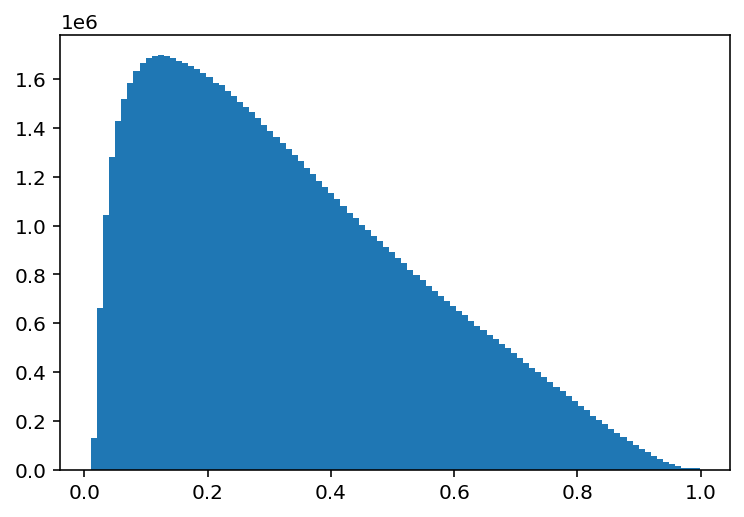

In [ ]:
# Define sample factor of 1000/number of datapoints

sample_size = 10000
corpus_size = len(df_spring)
sample_factor = sample_size / corpus_size

# We convert the corpus to a sparse matrix and reduce its dimensionality. We also keep its triangular part

X = [literal_eval(el) for el in df_spring.sample(sample_size)['LDA_15'].values.tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part

print('Number of non-zero components in similarity matrix:', len(simmat.data))
print('We check the size of the similarity matrix:', simmat.shape)
print('Ratio of non-zero components:', len(simmat.data)/simmat.shape[0]/simmat.shape[1])

plt.hist(simmat.data, bins=100)
plt.show()

In [ ]:
# Threshold value
thr = 0.66

# We set as 0 the values where the data is less than the threshold
simmat.data = np.where(simmat.data < thr, 0, simmat.data)

# We remove the zeros
simmat.eliminate_zeros()
len(simmat.data)
print('Estimated number of links in full corpus:', len(simmat.data)/2/sample_factor**2)

Estimated number of links in full corpus: 350100.13788288


# **5. Computing CSV files for Gephi**

Obtaining the Edge and Node CSVs in order to being able to represent our Topic Modelling Graphically (with Gephy).



### *5.1. Nodes CSV file*

In [ ]:
# In this cell, we check how good is the 'main_topic_15' column as target predictor.
# Since we have called the topics like with the same names as the disciplines 
# (adding a number in case we consider the discipline was repeated, i.e. 'Biomedicine 2'),
# we just check if this main topic is the same as the target. 
iters = 0
counter = 0
eval_num = len(df_spring)

for index, row in df_spring.iterrows():
  if iters == eval_num:
    break
  
  discip = row['main_topic_15']
  if any(map(str.isdigit, discip)):
    discip = discip[0:-2]
  if row['target'] == discip:
    counter +=1 
  iters += 1

print('Using the "main_topic_15" attribute as target predictor gives an accuracy of: ',counter/eval_num)

Using the "main_topic_15" attribute as target predictor gives an accuracy of:  0.10052910052910052


## Data Checkpoint 4

In [ ]:
sample_size = 2500
print('Creating a graph with', sample_size, 'nodes')
df_spring_sample = df_spring.sample(sample_size)
df_spring_sample['Id'] = [el for el in np.arange(sample_size)]
df_spring_sample[['Id','Keywords', 'Authors', 'Accesses', 
                  'Journal', 'main_topic_15']].to_csv(local_folder + 'Task 1 CheckPoints/CheckPoint4/' 
                                                      + 'df_spring_nodes.csv', index=False)

Creating a graph with 2500 nodes


### *5.2. Weights CSV file*

We have thought on having 100 links/weights per node. Since we have 2500 nodes that means we need around 250000 links in the sampled corpus.
We adjusted the thr value to 0.66 in order to obtain 253124 links which are close enough.

In [ ]:
# Same process but we end with the simmat matrix transformed to coordinate representation

X = [literal_eval(el) for el in df_spring_sample['LDA_15'].values.tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
simmat.data = np.where(simmat.data < thr, 0, simmat.data)
simmat.eliminate_zeros()
simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part
print('Number of links in sampled corpus:', len(simmat.data))


simmat = simmat.tocoo()


Number of links in sampled corpus: 253124


In [ ]:
pd.DataFrame([el for el in zip(simmat.row.tolist(),simmat.col.tolist(),simmat.data.tolist())],
             columns=['Source','Target','Weight']).to_csv(local_folder + 'Task 1 CheckPoints/CheckPoint4/'  + 'df_spring_edges.csv', index=False)